Demostration of the various functions of mod_sc.py


First identify Contextual anomalies (Talga et al 18 Figure 1a)

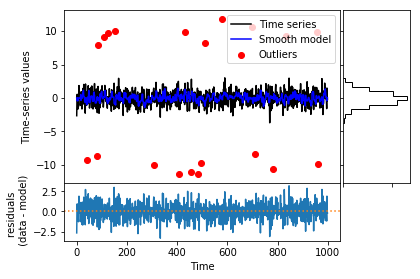

<Figure size 432x288 with 0 Axes>

In [16]:
import numpy as np
import scipy
import matplotlib.pylab as plt
import scipy.optimize as mcf
import scipy.signal as ssig
import matplotlib.gridspec as gridspec
import outlier_rejection as orej


#generate some fake random data to test the code. Specify the parameters of the fake data below
sd_true = 1.0
n_true  = 1000
n_outlier = 20
mean_outlier = 10.0
sd_outlier = 1.0


#make the fake data
data_y = np.random.randn(n_true)*sd_true
id_test = np.random.choice(np.arange(n_true), size=n_outlier, replace=False)
data_y[id_test] = np.random.randn(n_outlier)*sd_outlier + mean_outlier
idneg = np.random.choice(np.arange(n_outlier), size=n_outlier/2, replace=False)
data_y[id_test[idneg]] = -1*data_y[id_test[idneg]]

#Call the outlier rejection function defined above and test on the fake data.
id_out = orej.outlier_smooth(data_y,sd_check=4,
fname='running median',filter_size = 5,max_iteration=10,diagnostic_figure='show')

Now attempt to flag anomalous sub-sequences within a given series (Figure 2b Talagala et al 2018). Here a running median model is innapropriate as it would consider the outlying sequence as normal unless a very larger filter size is assumed. A global median is a better choice of smooth function here as the anomalous sub-sequence is still outnumbered by the abundance of well behaved data. A 'global median' fit is also better than a 'global mean' as it is robust to outliers and in this case completely disregards the outliying sequence.

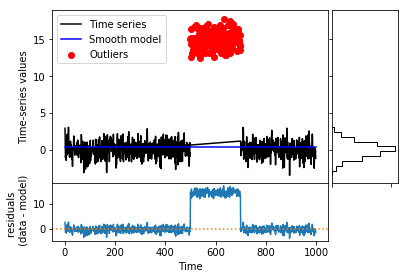

<Figure size 432x288 with 0 Axes>

In [17]:
# define the random sub-sequence
subsequence_size = 200
data_y = np.random.randn(n_true)*sd_true
id_test = np.arange(n_true/2,n_true/2+subsequence_size)
data_y[id_test] = np.random.randn(subsequence_size)*sd_outlier + 1.5*mean_outlier


#call to 'outlier_smooth'
idx_outlier = orej.outlier_smooth(data_y,sd_check=1,fname='global median',runtype='series',
                                  filter_size = 5,max_iteration=1,diagnostic_figure='show')



Now try a slightly more complex model. Simulate non-stationary time series (in this case some combination of periodic signal that increases with time as a polynomial).

In [18]:
#make the fake data
period = 200.0
amplitude = 2
t_ref = 400
amp_poly = 2
data_y = np.random.randn(n_true)*sd_true +  amplitude*np.sin(2*np.pi/period*np.arange(n_true)) + amp_poly*(np.arange(n_true)/t_ref)**2
id_test = np.random.choice(np.arange(n_true), size=n_outlier, replace=False)

idneg = np.random.choice(np.arange(n_outlier), size=n_outlier/2, replace=False)
mirror = np.ones(n_outlier)
mirror[idneg] = -1.
data_y[id_test] = amplitude*np.sin(2*np.pi/period*id_test) + amp_poly*(id_test/t_ref)**2 + mean_outlier*mirror




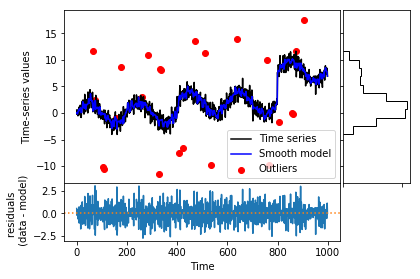

<Figure size 432x288 with 0 Axes>

In [21]:
id_out = orej.outlier_smooth(data_y,sd_check=3,fname='running median',runtype='series',filter_size = 5,max_iteration=2,diagnostic_figure='show')


The 'outlier_smooth' fits a smooth function to identify outliers inconsistent with the evolving time series. A standard sigma clip using just the mean and standard deviation would fail here as the distribution is now multimodal and non-stationary. 

The examples above are all looking for outliers from within a single time-series. Now introduce a set of multiple time series data with one entire anomalous time series. The objective is now to identify anomalies between multiple time series rather than within a single time series (Figure 2c from Talagala et al 2018).

In [10]:
#make the fake data
period = 200.0
amplitude = 2
t_ref = 200
amp_poly = 2

sd_background = 3.0
n_epoch  = 1000
n_timeseries = 100
id_outlier = 23
time_anomaly = 35
grad_anomaly = 0.1
diagnostic_figure = 'show'
data_y = np.reshape( np.random.randn(n_epoch * n_timeseries), (n_epoch,n_timeseries) )

data_y[:,time_anomaly] = np.random.randn(n_epoch)*sd_background +  amplitude*np.sin(2*np.pi/period*np.arange(n_epoch)) + amp_poly*(np.arange(n_true)/t_ref)**2
id_test = np.random.choice(np.arange(n_epoch), size=n_outlier, replace=False)

idneg = np.random.choice(np.arange(n_outlier), size=n_outlier/2, replace=False)
mirror = np.ones(n_outlier)
mirror[idneg] = -1.
data_y[id_test,time_anomaly] = amplitude*np.sin(2*np.pi/period*id_test) + amp_poly*(id_test/t_ref)**2 + mean_outlier*mirror


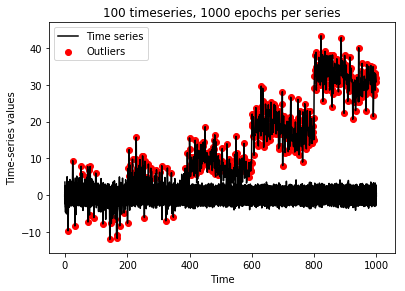

In [11]:
id_out = orej.outlier_smooth(data_y,sd_check=5,fname='running median',runtype='parallel',filter_size = 5,max_iteration=10,diagnostic_figure='show')


In the above figure we have the same increasing sinusoid as with the previous example, but we also have 99 well behaved stationary time series that oscilate around zero. 'outlier_smooth' now flags the entire series as 'bad' as the iterative-smooth-model fitting now takes place epoch-by-epoch across all the 100 time-series rather than across all the epochs for a single time series.